In [1]:
# Install dependecies
!pip install -q datasets transformers
!pip install accelerate
!pip install -U pip wheel
!pip install ensemble-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.1
    Uninstalling wheel-0.41.1:
      Succe

In [2]:
# Load the Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Run this cell to avoid any error in ensemble-transformer library
# After running it, please restart the kernel
import shutil
import os

src_path = '/content/drive/MyDrive/Resource/config.py'
dst_path = '/usr/local/lib/python3.10/dist-packages/ensemble_transformers'
os.remove(dst_path + '/config.py')
shutil.copy(src_path, dst_path)

'/usr/local/lib/python3.10/dist-packages/ensemble_transformers/config.py'

In [4]:
# Dataset labels id
id2label = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [5]:
from ensemble_transformers import EnsembleModelForImageClassification
# Load the models
# pre-trained model checkpoint to be used for fine-tuning
model_names = ["ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-3" ,
               "ALM-AHME/convnextv2-large-1k-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20-Shuffled-3rd",
               "ALM-AHME/beit-large-patch16-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20-Shuffled-3rd"]


ensemble = EnsembleModelForImageClassification.from_multiple_pretrained(*model_names)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [6]:
#load libraries
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from ensemble_transformers import EnsembleModelForImageClassification
import torch
from PIL import Image
import os
import time

In [8]:
from datasets import load_dataset
from datasets import concatenate_datasets

# Load the train/val dataset
dataset = load_dataset("/content/drive/MyDrive/Skin_Cancer/Augmented-Final", data_dir="./train+val/")
# Load the dataset
test_dataset=load_dataset("/content/drive/MyDrive/Skin_Cancer/Augmented-Final/test")
# merge both datasets
dataset_cc = concatenate_datasets([dataset['train'], test_dataset['train']])

# split up training into training + validation
splits = dataset_cc.train_test_split(test_size=0.2,shuffle=True, seed=35)
test_ds = splits['test']
train_splits=splits['train'].train_test_split(test_size=0.25)
train_ds = train_splits['train']
val_ds = train_splits['test']

Resolving data files:   0%|          | 0/4864 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/1223 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
# Load the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble.to(device)

In [14]:
import collections

# Target list is the ground truth labels
target_list = []
# Prediction list is the predicted labels
pred_list = []

# Folder index is the labelid for each corresponding label class
folder_index = 0

# get the start time
start_time = time.time()

for image in test_ds:
    im = image['image']
    true_label=image['label']

    with torch.no_grad():
        outputs  = ensemble(im).logits
        ensemble_outputs = torch.stack(outputs)
        avg_ensemble = torch.mean(ensemble_outputs, dim=0)
        predicted_label = avg_ensemble.to('cpu').argmax(-1).item()
        # print(predicted_label)
        # print(logits)

    # print(final_pred)
    target_list.append(true_label)
    pred_list.append(predicted_label)

end_time = time.time()

print("Target: " , collections.Counter(target_list))
print("Predicted: " , collections.Counter(pred_list))



elapsed_time = end_time - start_time
print('\nTotal Execution time:', elapsed_time, 'seconds')

Target:  Counter({6: 180, 5: 178, 3: 177, 1: 175, 0: 175, 2: 168, 4: 165})
Predicted:  Counter({6: 180, 5: 178, 3: 177, 0: 175, 1: 174, 2: 169, 4: 165})

Total Execution time: 189.12782287597656 seconds


## Visualizing Results

In [11]:

#!pip install wandb

#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [15]:
# Make a copy of each prediction list
target_list_copy = target_list
pred_list_copy = pred_list

<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

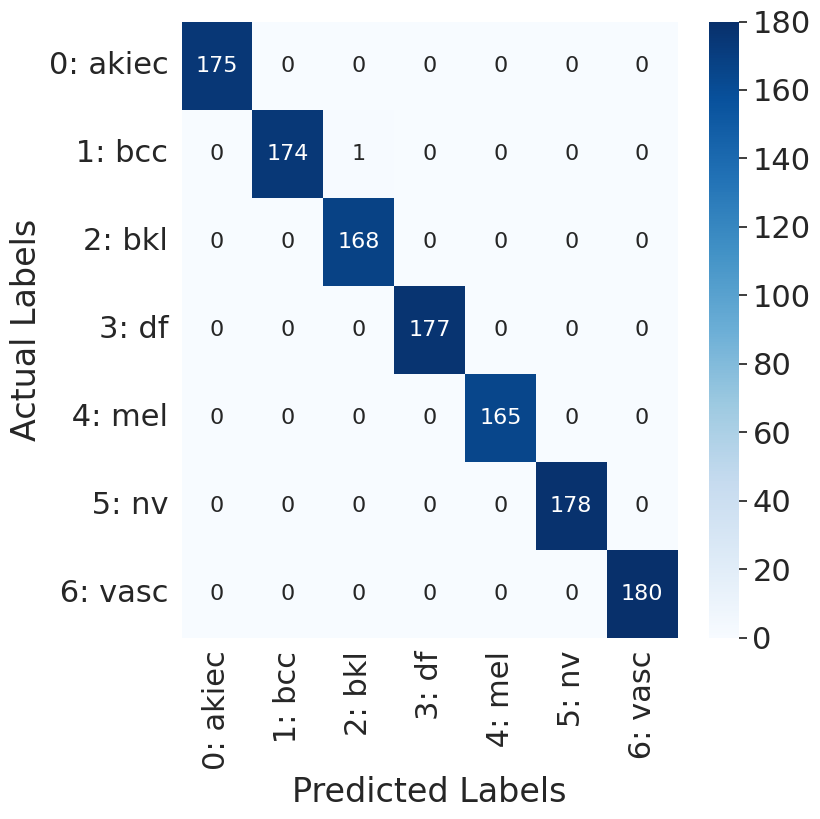

In [17]:
# test_pred_labels=pred_list_copy.argmax(axis=1)
# Plot Confusion Matrix

data = confusion_matrix(target_list_copy,pred_list_copy,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(data, columns=['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'], index = ['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [16]:
# Classification report
print(classification_report(target_list_copy,pred_list_copy,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       175
           1     1.0000    0.9943    0.9971       175
           2     0.9941    1.0000    0.9970       168
           3     1.0000    1.0000    1.0000       177
           4     1.0000    1.0000    1.0000       165
           5     1.0000    1.0000    1.0000       178
           6     1.0000    1.0000    1.0000       180

    accuracy                         0.9992      1218
   macro avg     0.9992    0.9992    0.9992      1218
weighted avg     0.9992    0.9992    0.9992      1218



In [19]:
# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

In [20]:
beit_test_result=evaluation_summary("Ensemble-Transformer-Classification-Test-data Shuffled", pred_list_copy , target_list_copy)

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,Ensemble-Transformer-Classification-Test-data Shuffled,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000,0.999000
